### Reference Notbooks
4. Natural language Processing IV (Section 5.4 thne 5.6)
4. NLP Exercise - do with student

### Steps to Follow
1. Try NaiveBayes classiffier first
2. Data Cleaning, lemming, etc
3. TFIDF
5. Try Random Forest (or K-means with only 2 clases?)

In [58]:
# Import necessary libraries
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [59]:
# Importing the Training Data file
df= pd.read_csv('training_data_lowercase.csv', sep='\t', names=['tag', 'text'])
df.head(10)

,tag,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...
5,0,racist alabama cops brutalize black boy while ...
6,0,fresh off the golf course
7,0,trump said some insanely racist stuff inside t...
8,0,former cia director slams trump over un bullying
9,0,brand-new pro-trump ad features so much a** ki...


In [60]:
#Defining target and features
X = df['text']
y = df['tag']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
### CLEAN AND TOKENIZE DATA
def clean_tokenize(phrase):
    return [word.lower() for word in word_tokenize(phrase) if word.isalpha()]

X_train_clean = X_train.apply(clean_tokenize)
X_test_clean = X_test.apply(clean_tokenize)

X_train_clean.head(10)

8891                                                  [so]
25115    [final, reckoning, approaches, for, obama, hig...
26933    [illinois, budget, talks, fizzle, amid, partis...
26971    [clinton, spokesman, ig, report, shows, no, cl...
11387    [busted, nancy, pelosi, claims, no, meeting, w...
9948     [heartwarming, hugs, and, kisses, from, potus,...
14165    [hillary, battle, plan, use, her, sex, offende...
14712    [radical, ny, attorney, general, cracking, dow...
11974                   [obama, blames, russia, for, loss]
30066    [factbox, one, planet, summit, turns, to, priv...
Name: text, dtype: object

In [62]:
### OLD VERSION OF CLEANING
"""
def clean_data(text):        
    text = ''.join(f' {e} ' if e in string.punctuation else e for e in text)  # Add spaces around special characters
    text = ''.join(e for e in text if e.isalpha() or e.isspace())  # Remove special characters and numbers
    text = ' '.join(word for word in text.split() if len(word) > 1)  # Remove single characters
    text = text.lstrip()  # Remove single characters from the start
    text = ' '.join(text.split())  # Substitute multiple spaces with single space
    text = text.replace('b ', '')  # Remove prefixed 'b'
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    
    # Get the Spanish stopwords
    stop_words = set(stopwords.words('spanish'))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

X_train_clean = X_train.apply(clean_data)
X_train_clean.head(10)
"""

"\ndef clean_data(text):        \n    text = ''.join(f' {e} ' if e in string.punctuation else e for e in text)  # Add spaces around special characters\n    text = ''.join(e for e in text if e.isalpha() or e.isspace())  # Remove special characters and numbers\n    text = ' '.join(word for word in text.split() if len(word) > 1)  # Remove single characters\n    text = text.lstrip()  # Remove single characters from the start\n    text = ' '.join(text.split())  # Substitute multiple spaces with single space\n    text = text.replace('b ', '')  # Remove prefixed 'b'\n    text = text.lower()  # Convert to lowercase\n    text = text.strip()  # Remove leading/trailing whitespace\n    \n    # Get the Spanish stopwords\n    stop_words = set(stopwords.words('spanish'))\n    # Remove stopwords\n    text = ' '.join([word for word in text.split() if word not in stop_words])\n    \n    return text\n\nX_train_clean = X_train.apply(clean_data)\nX_train_clean.head(10)\n"

In [63]:
### Lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a sentence or text
def lemmatize_text(words):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

X_train_lm = X_train_clean.apply(lemmatize_text)
X_test_lm = X_test_clean.apply(lemmatize_text)

In [64]:
# Remove stopwords
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

X_train_sw = X_train_lm.apply(remove_stopwords)
X_test_sw = X_test_lm.apply(remove_stopwords)

In [65]:
# Recompose the phrases
X_train_final = X_train_sw.apply(lambda row: " ".join(row))
X_test_final = X_test_sw.apply(lambda row: " ".join(row))

In [66]:
## Vectorization
bow_vect = CountVectorizer(max_features=1000)

# fit creates one entry for each different word seen
X_train_vect = bow_vect.fit_transform(X_train_final).toarray()
X_test_vect = bow_vect.transform(X_test_final).toarray()

In [67]:
### Testing XGB Classifier
#Creating and Training the XGB model
xgb_model = XGBClassifier().fit(X_train_vect, y_train)
## Predict for the Test Dataset
y_pred = xgb_model.predict(X_test_vect)

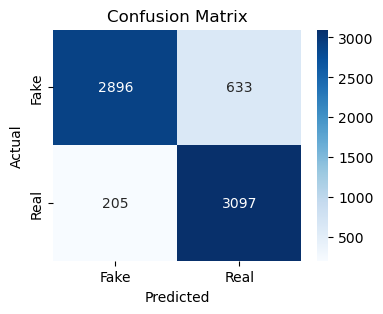

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      3529
           1       0.83      0.94      0.88      3302

    accuracy                           0.88      6831
   macro avg       0.88      0.88      0.88      6831
weighted avg       0.88      0.88      0.88      6831

Accuracy Score: 0.8773


In [68]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

acc_score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc_score:.4f}")